# Comparação de Modelos de Machine Learning para predição de Gorjetas

Este caderno é voltado para a comparação de modelos de regressão e classificação, com o objetivo de identificar os melhores modelos para a previsão e classificação dos dados. O processo é dividido em várias etapas cruciais:

* **Tratamento e Transformação de Dados**:
    * A primeira etapa envolve a preparação dos dados para análise. Isso inclui a limpeza de dados faltantes, normalização, codificação de variáveis categóricas e outras transformações necessárias para garantir que os dados estejam prontos para alimentar os modelos.

* **Treinamento e Avaliação de Modelos**:
    * Nessa etapa, diferentes modelos de regressão (como LinearRegression, KNeighborsRegressor, SVR, DummyRegressor) e classificação (como LogisticRegression, KNeighborsClassifier) são treinados e avaliados. Para cada modelo, são calculadas métricas de desempenho como precisão, recall, F1-score, MAE, MSE e R², permitindo uma comparação detalhada de sua eficácia.

* **Comparação de Modelos** :
    * Através de uma análise comparativa, são avaliadas as forças e fraquezas de cada modelo com base nos resultados obtidos. Essa comparação abrange tanto as métricas de avaliação quanto as predições de cada modelo, considerando a adequação a diferentes tipos de dados e a capacidade de captura de padrões.

* **Geração de Insights**:
    * Por fim, são extraídos insights com base nas comparações entre os modelos. São apresentados gráficos e tabelas para ilustrar a performance de cada abordagem, destacando as melhores opções para o problema em questão. O objetivo é entender quais modelos têm o melhor desempenho em termos de generalização, precisão e adequação ao contexto dos dados.

## Tratamento e Transformação de dados

* Bibliotecas:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,  ShuffleSplit, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib

* Leitura dos dados:

In [2]:
dados = pd.read_csv('https://raw.githubusercontent.com/atlantico-academy/datasets/refs/heads/main/tips.csv')

In [3]:
dados_dict = pd.read_csv('../data/external/dictionary.csv')

In [4]:
dados.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [5]:
dados_dict.head(10)

,variavel,descricao,tipo,subtipo
0,total_bill,Representa o valor total da conta em dólares,quantitativa,contínua
1,tip,Representa o valor da gorjeta em dólares,quantitativa,contínua
2,sex,Indica o sexo da pessoa (Masculino ou Feminino),qualitativa,nominal
3,smoker,Indica se a pessoa é fumante ou não,qualitativa,nominal
4,day,Indica o dia da semana em que a refeição ocorreu,qualitativa,nominal
5,time,Indica se a refeição ocorreu no almoço ou jantar,qualitativa,nominal
6,size,Indica o número de pessoas no grupo,quantitativa,discreta


* Verificando estrutura:

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


Valores númericos:

In [7]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
total_bill,244.0,19.785943,8.902412,3.07,13.3475,17.795,24.1275,50.81
tip,244.0,2.998279,1.383638,1.00,2.0000,2.900,3.5625,10.00
size,244.0,2.569672,0.951100,1.00,2.0000,2.000,3.0000,6.00


Valores de string:

In [8]:
dados.describe(include='object').T

,count,unique,top,freq
sex,244,2,Male,157
smoker,244,2,No,151
day,244,4,Sat,87
time,244,2,Dinner,176


* Verificando os Valores Faltantes:

In [9]:
valores_nulos = dados.isnull().values.any()

if valores_nulos:
    print("Há valores nulos na tabela.")
else:
    print("Não há valores nulos na tabela.")

Não há valores nulos na tabela.


In [10]:
print(f'Verificando valores faltantes : \n\n{dados.isna().sum()}')

Verificando valores faltantes : 

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64


Acima vemos que não há valores nulos no dataset.

* Verificando os Valores discrepantes:

In [11]:
# Função para identificar outliers usando o IQR
def detect_outliers_iqr(dados, column):
    Q1 = dados[column].quantile(0.25)  # Primeiro quartil
    Q3 = dados[column].quantile(0.75)  # Terceiro quartil
    IQR = Q3 - Q1                     # Intervalo Interquartil
    
    lower_bound = Q1 - 1.5 * IQR      # Limite inferior
    upper_bound = Q3 + 1.5 * IQR      # Limite superior
    
    outliers = dados[(dados[column] < lower_bound) | (dados[column] > upper_bound)]
    return outliers

In [12]:
# Detectando outliers apenas para colunas numéricas
for col in dados.select_dtypes(include=[np.number]).columns:  # Filtra apenas colunas numéricas
    outliers = detect_outliers_iqr(dados, col)
    print(f"Outliers na coluna '{col}':\n{outliers}\n")

Outliers na coluna 'total_bill':
     total_bill    tip     sex smoker   day    time  size
59        48.27   6.73    Male     No   Sat  Dinner     4
102       44.30   2.50  Female    Yes   Sat  Dinner     3
142       41.19   5.00    Male     No  Thur   Lunch     5
156       48.17   5.00    Male     No   Sun  Dinner     6
170       50.81  10.00    Male    Yes   Sat  Dinner     3
182       45.35   3.50    Male    Yes   Sun  Dinner     3
184       40.55   3.00    Male    Yes   Sun  Dinner     2
197       43.11   5.00  Female    Yes  Thur   Lunch     4
212       48.33   9.00    Male     No   Sat  Dinner     4

Outliers na coluna 'tip':
     total_bill    tip     sex smoker   day    time  size
23        39.42   7.58    Male     No   Sat  Dinner     4
47        32.40   6.00    Male     No   Sun  Dinner     4
59        48.27   6.73    Male     No   Sat  Dinner     4
141       34.30   6.70    Male     No  Thur   Lunch     6
170       50.81  10.00    Male    Yes   Sat  Dinner     3
183       23

Acima temos uma lista com os valores discrepantes das colunas numéricas.

* Estruturação de Variáveis:

In [13]:
# Definindo a variável-alvo
target_variable = 'tip'

# Identificando variáveis inúteis (nenhuma nesse caso)
useless_variables = (
    dados_dict
    .query("tipo == 'inútil'")
    .variavel
    .to_list()
)

# Variáveis nominais (não incluímos a variável-alvo)
nominal_variables = (
    dados_dict
    .query("subtipo == 'nominal' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis ordinais (nenhuma foi definida como ordinal no dicionário)
ordinal_variables = (
    dados_dict
    .query("subtipo == 'ordinal' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis contínuas
continuous_variables = (
    dados_dict
    .query("subtipo == 'contínua' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis discretas
discrete_variables = (
    dados_dict
    .query("subtipo == 'discreta' and variavel != @target_variable")
    .variavel
    .to_list()
)

* Separando X (variáveis explicativas) e y (variável-alvo):

In [14]:
X = dados.drop(columns=[target_variable] + useless_variables)
y = dados[target_variable]

In [15]:
print("Variáveis nominais:", nominal_variables)
print("Variáveis contínuas:", continuous_variables)
print("Variáveis discretas:", discrete_variables)
print("\nX (features):\n", X)
print("\ny (target):\n", y)

Variáveis nominais: ['sex', 'smoker', 'day', 'time']
Variáveis contínuas: ['total_bill']
Variáveis discretas: ['size']

X (features):
      total_bill     sex smoker   day    time  size
0         16.99  Female     No   Sun  Dinner     2
1         10.34    Male     No   Sun  Dinner     3
2         21.01    Male     No   Sun  Dinner     3
3         23.68    Male     No   Sun  Dinner     2
4         24.59  Female     No   Sun  Dinner     4
..          ...     ...    ...   ...     ...   ...
239       29.03    Male     No   Sat  Dinner     3
240       27.18  Female    Yes   Sat  Dinner     2
241       22.67    Male    Yes   Sat  Dinner     2
242       17.82    Male     No   Sat  Dinner     2
243       18.78  Female     No  Thur  Dinner     2

[244 rows x 6 columns]

y (target):
 0      1.01
1      1.66
2      3.50
3      3.31
4      3.61
       ... 
239    5.92
240    2.00
241    2.00
242    1.75
243    3.00
Name: tip, Length: 244, dtype: float64


O código acima organiza e prepara os dados de forma sistemática para análise ou modelagem. Ele facilita a aplicação de diferentes técnicas a cada tipo de variável, como codificação (para nominais) ou normalização (para contínuas)

* Pipelines de pré-processamento por tipo de variável:

In [16]:

nominal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')),  # Substituir valores faltantes pela moda
    ("encoding", OneHotEncoder(sparse_output=False)),  # Codificação one-hot
])

continuous_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='mean')),  # Substituir valores faltantes pela média
    ("normalization", StandardScaler()),  # Normalização (média = 0, desvio padrão = 1)
])

discrete_preprocessor = Pipeline(steps=[
    ("missing", KNNImputer()),  # Substituir valores faltantes com base nos vizinhos mais próximos
    ("normalization", StandardScaler()),  # Normalização
])


Esse código acima organiza pipelines para pré-processar variáveis diferentes (nominais, ordinais, contínuas e discretas). Cada tipo de variável tem necessidades específicas, como tratamento de valores faltantes ou codificação.

* Selecionando variáveis com base no dados_dict:

In [17]:
# Criando o transformador por tipo de variável
preprocessor = ColumnTransformer(transformers=[
    ("nominal", nominal_preprocessor, nominal_variables),
    ("continuous", continuous_preprocessor, continuous_variables),
    ("discrete", discrete_preprocessor, discrete_variables),
])

As variáveis nominais, contínuas e discretas são extraídas do dicionário de dados com base no subtipo. Isso assegura que cada tipo de dado seja tratado com o pipeline apropriado.

* Aplicando preprocessor:

In [18]:
X_preprocessed = preprocessor.fit_transform(X)

Acima Treina o pipeline no dataset (fit) e transforma os dados (transform) de acordo com os passos definidos.

In [19]:
print("Dados pré-processados:")
print(X_preprocessed)

Dados pré-processados:
[[ 1.          0.          1.         ...  0.         -0.31471131
  -0.60019263]
 [ 0.          1.          1.         ...  0.         -1.06323531
   0.45338292]
 [ 0.          1.          1.         ...  0.          0.1377799
   0.45338292]
 ...
 [ 0.          1.          0.         ...  0.          0.3246295
  -0.60019263]
 [ 0.          1.          1.         ...  0.         -0.2212865
  -0.60019263]
 [ 1.          0.          1.         ...  0.         -0.1132289
  -0.60019263]]


## Análise Comparativa de Modelos de Regressão

* ### **Avaliação e validação dos Modelos**

In [20]:
models = [DummyRegressor(strategy='mean'), LinearRegression(), KNeighborsRegressor(n_neighbors=5), SVR()]

In [21]:
metrics = [
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_mean_absolute_percentage_error',
    'r2',
]

In [22]:
monte_carlo = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)

In [23]:
results_total = None
for model in models:
    model_name = model.__class__.__name__
    print(f"rodando para o modelo: {model_name}")
    approach = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model),
    ])

    scores = cross_validate(
        approach, X, y,
        scoring=metrics, 
        cv=monte_carlo
    )
    results_model = pd.DataFrame(scores)
    results_model['model'] = model_name
    if results_total is None:
        results_total = results_model
    else:
        results_total = pd.concat([results_total, results_model])

rodando para o modelo: DummyRegressor
rodando para o modelo: LinearRegression
rodando para o modelo: KNeighborsRegressor
rodando para o modelo: SVR


In [24]:
results_total.groupby('model').agg(['mean', 'std']).T

model                                         DummyRegressor  \
fit_time                                mean        0.013411   
                                        std         0.006490   
score_time                              mean        0.006656   
                                        std         0.005024   
test_neg_mean_absolute_error            mean       -1.097528   
                                        std         0.053536   
test_neg_mean_squared_error             mean       -1.913626   
                                        std         0.337541   
test_neg_mean_absolute_percentage_error mean       -0.478500   
                                        std         0.056960   
test_r2                                 mean       -0.050466   
                                        std         0.067162   

model                                         KNeighborsRegressor  \
fit_time                                mean             0.022550   
                                        std              0.004552   
score_time                              mean             0.014626   
                                        std              0.004642   
test_neg_mean_absolute_error            mean            -0.842865   
                                        std              0.069564   
test_neg_mean_squared_error             mean            -1.248358   
                                        std              0.236088   
test_neg_mean_absolute_percentage_error mean            -0.339017   
                                        std              0.034385   
test_r2                                 mean             0.309460   
                                        std              0.116482   

model                                         LinearRegression       SVR  
fit_time                                mean          0.034297  0.021402  
                                        std           0.035623  0.006740  
score_time                              mean          0.013172  0.009864  
                                        std           0.005345  0.004961  
test_neg_mean_absolute_error            mean         -0.796831 -0.755127  
                                        std           0.061810  0.051762  
test_neg_mean_squared_error             mean         -1.132064 -1.051083  
                                        std           0.177299  0.164498  
test_neg_mean_absolute_percentage_error mean         -0.312493 -0.296390  
                                        std           0.027163  0.024975  
test_r2                                 mean          0.373997  0.420621  
                                        std           0.087094  0.058268

**PREPARAÇÃO DOS DADOS PARA OS GRÁFICOS**:

In [25]:
# Pivotar os dados para facilitar a visualização
results_pivot = results_total.pivot_table(index='model', aggfunc=['mean', 'std'])

# Renomear colunas para facilitar o acesso
results_pivot.columns = ['_'.join(col).strip() for col in results_pivot.columns]

# Resetar o índice para usar os modelos no eixo X
results_pivot = results_pivot.reset_index()

**Boxplot dos Tempos de Treinamento e Previsão**

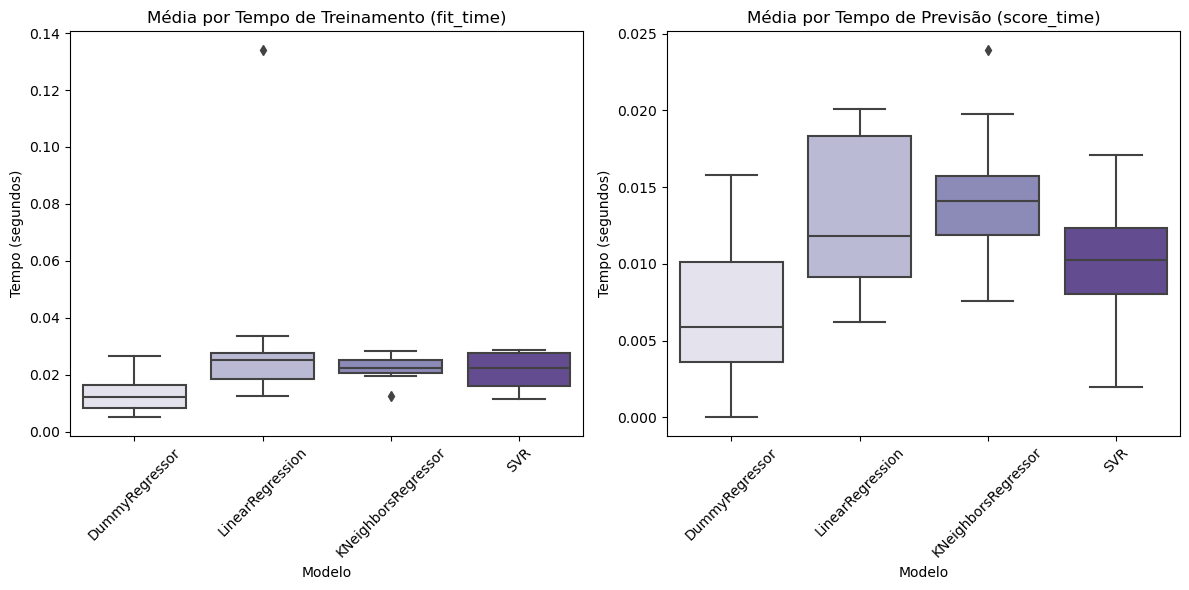

In [56]:
plt.figure(figsize=(12, 6))

# Tempo de treinamento (fit_time)
plt.subplot(1, 2, 1)
sns.boxplot(data=results_total, x='model', y='fit_time', palette='Purples')
plt.title('Média por Tempo de Treinamento (fit_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

# Tempo de previsão (score_time)
plt.subplot(1, 2, 2)
sns.boxplot(data=results_total, x='model', y='score_time', palette='Purples')
plt.title('Média por Tempo de Previsão (score_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

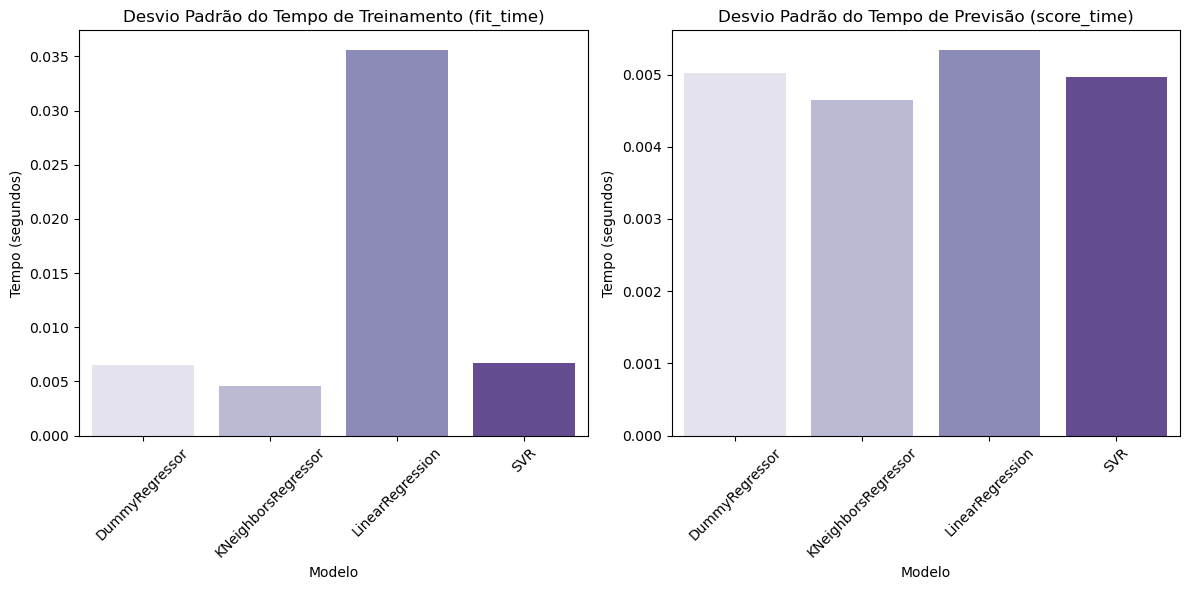

In [55]:
std_results = results_total.groupby('model').std().reset_index()

plt.figure(figsize=(12, 6))

# Tempo de treinamento (fit_time) - desvio padrão
plt.subplot(1, 2, 1)
sns.barplot(data=std_results, x='model', y='fit_time', palette='Purples')
plt.title('Desvio Padrão do Tempo de Treinamento (fit_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

# Tempo de previsão (score_time) - desvio padrão
plt.subplot(1, 2, 2)
sns.barplot(data=std_results, x='model', y='score_time', palette='Purples')
plt.title('Desvio Padrão do Tempo de Previsão (score_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Gráficos Comparativos para Métricas**

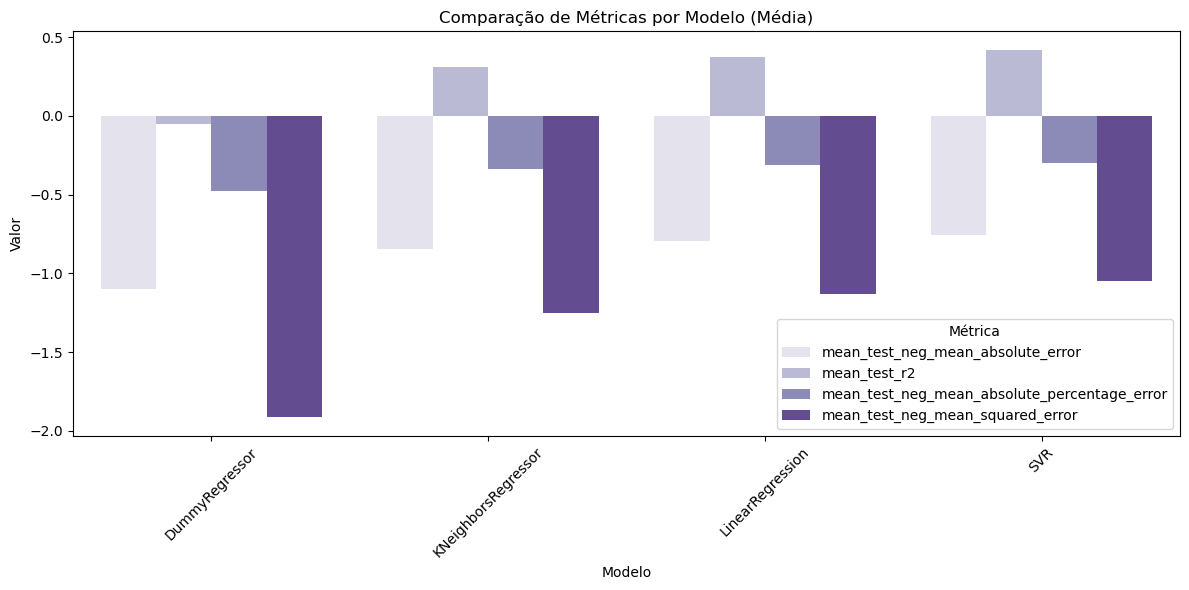

In [53]:
metrics_to_plot = ['mean_test_neg_mean_absolute_error', 'mean_test_r2','mean_test_neg_mean_absolute_percentage_error','mean_test_neg_mean_squared_error']
results_melted = results_pivot.melt(id_vars='model', value_vars=metrics_to_plot, var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='model', y='Valor', hue='Métrica', palette='Purples')
plt.title('Comparação de Métricas por Modelo (Média)')
plt.ylabel('Valor')
plt.xlabel('Modelo')
plt.xticks(rotation=45)
plt.legend(title='Métrica')
plt.tight_layout()
plt.show()


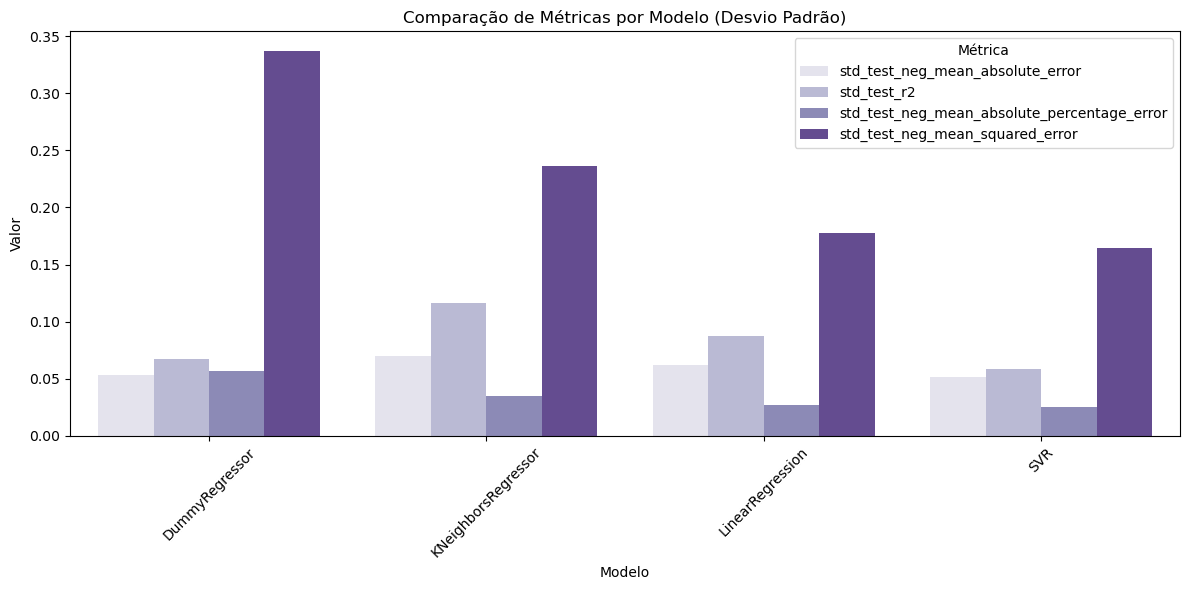

In [54]:
metrics_to_plot = ['std_test_neg_mean_absolute_error', 'std_test_r2','std_test_neg_mean_absolute_percentage_error','std_test_neg_mean_squared_error']
results_melted = results_pivot.melt(id_vars='model', value_vars=metrics_to_plot, var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='model', y='Valor', hue='Métrica', palette='Purples')
plt.title('Comparação de Métricas por Modelo (Desvio Padrão)')
plt.ylabel('Valor')
plt.xlabel('Modelo')
plt.xticks(rotation=45)
plt.legend(title='Métrica')
plt.tight_layout()
plt.show()

1. **Tempos de Treinamento e de Previsão**
* **fit_time**
   * **Média (mean)**: Indica o tempo médio necessário para treinar cada modelo.
      * Observação: O LinearRegression tem o maior tempo médio de treinamento (0.014686), seguido pelos outros modelos com tempos similares.
   * **Desvio padrão (std)**: Mede a variabilidade no tempo de treinamento entre execuções.
      * Observação: LinearRegression também apresenta a maior variabilidade (0.019117), enquanto o KNeighborsRegressor e o SVR têm menor variação.
* **score_time**
   * **Média**: Refere-se ao tempo médio necessário para realizar predições com o modelo.
      * Observação: O SVR tem o menor tempo médio (0.001715), enquanto o DummyRegressor é o mais lento para prever (0.004356).
   * **Desvio padrão**: A variabilidade é baixa para todos os modelos, indicando tempos consistentes de predição.

2. **Métricas de Avaliação de Erros**
* **test_neg_mean_absolute_error (MAE)**
   * MAE é o erro médio absoluto (valores negativos indicam erro porque estamos usando a versão "negativa" da métrica). Quanto mais próximo de 0, melhor.
   * Análise:
      * O DummyRegressor (modelo de base) tem o maior erro médio absoluto (-1.097528), pois ele apenas prevê a média, sem levar os dados em consideração.
      * O SVR apresenta o menor erro médio absoluto (-0.755127), indicando que é o modelo com melhor desempenho em termos de previsões mais próximas dos valores reais.

* **test_neg_mean_squared_error (MSE)**
   * O MSE mede o erro médio ao quadrado, penalizando erros maiores. Valores mais próximos de 0 são melhores.
   * Análise:
      * O DummyRegressor tem o maior erro (-1.913626), enquanto o SVR novamente apresenta o menor erro (-1.051083), reforçando sua superioridade.

* **test_neg_mean_absolute_percentage_error (MAPE)**
   * MAPE mede o erro médio percentual absoluto. Novamente, valores mais próximos de 0 são melhores.
   * Análise:
      * O DummyRegressor apresenta um erro percentual alto (-47.85%), enquanto o SVR apresenta o menor erro percentual (-29.63%), mostrando que é mais confiável.


3. **Coeficiente de Determinação (test_r2)**

* O R² mede a proporção da variância explicada pelo modelo. Valores positivos próximos de 1 indicam bom desempenho, enquanto valores negativos sugerem que o modelo está pior que uma previsão baseada na média.
* Análise:
   * DummyRegressor: O R² negativo (-0.050466) confirma que ele não consegue explicar a variância dos dados.
   * KNeighborsRegressor e LinearRegression: Têm R² positivos e razoáveis (0.309460 e 0.373997, respectivamente).
   * SVR: Obteve o melhor R² (0.420621), sugerindo que é o modelo mais eficaz para capturar os padrões dos dados.


* ### **Predição dos Modelos**

Divisão em treino e teste:

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Aplicar o pré-processador aos dados de treino e teste
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [59]:
# Verificando o tamanho dos dados transformados
print("Shape of X_train_transformed:", X_train_transformed.shape)
print("Shape of X_test_transformed:", X_test_transformed.shape)

Shape of X_train_transformed: (195, 12)
Shape of X_test_transformed: (49, 12)


In [60]:
# Dicionário para armazenar os modelos treinados
trained_models = {}
# Treinando os modelos com os dados transformados
for model in models:
    model_name = type(model).__name__
    model.fit(X_train_transformed, y_train)
    trained_models[model_name] = model


In [61]:
# Fazendo predições
predictions = {}
for model_name, trained_model in trained_models.items():
    y_pred = trained_model.predict(X_test_transformed)
    predictions[model_name] = y_pred
    print(f"Predictions for {model_name}:")
    print(y_pred[:5])  # Exibindo as primeiras 5 predições


Predictions for DummyRegressor:
[3.08779487 3.08779487 3.08779487 3.08779487 3.08779487]
Predictions for LinearRegression:
[2.91436632 2.00292613 3.96425583 3.76380832 2.14836306]
Predictions for KNeighborsRegressor:
[3.18  1.976 3.534 2.834 2.786]
Predictions for SVR:
[3.17244791 1.86608451 4.08187114 3.148112   2.13794928]


1. **Predictions for DummyRegressor**:
[3.08779487, 3.08779487, 3.08779487, 3.08779487, 3.08779487]

* **Análise**: O DummyRegressor sempre retorna a média do valor da gorjeta no conjunto de treino.
* **Interpretação**: Este modelo não captura nenhuma relação entre as variáveis explicativas e o valor da gorjeta. Todas as predições são idênticas e refletem apenas o valor médio de treino. Ele serve como baseline para comparação.

2. **Predictions for LinearRegression**:
[2.91436632, 2.00292613, 3.96425583, 3.76380832, 2.14836306]

* **Análise**: O modelo tenta capturar uma relação linear entre as variáveis explicativas e a variável-alvo. As predições variam de 2.00 a 3.96.
* **Interpretação**: As predições mostram variação com base nos dados, indicando que o modelo está respondendo às características dos exemplos de entrada.
Este modelo é eficiente para relações aproximadamente lineares. No entanto, se houver relações não lineares significativas, ele pode apresentar limitações.

3. **Predictions for KNeighborsRegressor**:
[3.18, 1.976, 3.534, 2.834, 2.786]

* **Análise**: O KNeighborsRegressor faz predições baseadas na média dos valores da gorjeta nos "k" vizinhos mais próximos no espaço das variáveis explicativas.
* **Interpretação**: As predições refletem os valores locais, mas podem ser suavizadas pela média dos vizinhos.
Esse modelo é mais adequado para padrões não lineares, mas depende da densidade dos dados para capturar variações corretamente.
Algumas predições (como 1.976) diferem significativamente do valor médio, sugerindo que ele está ajustando bem a região correspondente.

4. **Predictions for SVR (Support Vector Regressor)**:
[3.17244791, 1.86608451, 4.08187114, 3.148112, 2.13794928]

* **Análise**: O SVR faz predições baseando-se em um modelo que maximiza a margem para erros dentro de um limite tolerado, o que permite capturar padrões complexos e não lineares.
* **Interpretação**:
As predições variam amplamente (1.87 a 4.08), indicando que o modelo está capturando nuances nos dados.
Comparado aos outros modelos, o SVR pode ser mais robusto em cenários onde a relação entre as variáveis explicativas e o valor da gorjeta é mais complicada.

## Análise Comparativa de Modelos de Classificação

* ###  **Avaliação dos Modelos**

In [62]:
# Definir os modelos de classificação
models = [
    LogisticRegression(),
    KNeighborsClassifier()
]

In [63]:
# Armazenar relatórios de classificação
reports = {}

In [64]:
# Divida y em quartis (4 categorias)
y_categorical = pd.qcut(y, q=4, labels=["Muito Baixa", "Baixa", "Alta", "Muito Alta"])
print("Categorias geradas:", y_categorical.unique())

Categorias geradas: ['Muito Baixa', 'Alta', 'Muito Alta', 'Baixa']
Categories (4, object): ['Muito Baixa' < 'Baixa' < 'Alta' < 'Muito Alta']


In [65]:
y_categorical = pd.qcut(y, q=4, labels=["Muito Baixa", "Baixa", "Alta", "Muito Alta"])

# Verifique o tamanho de y_categorical
print("Tamanho de y_categorical:", len(y_categorical))


Tamanho de y_categorical: 244


In [66]:
# Agora, divida os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [67]:
# Verifique os tamanhos após a divisão
print("Tamanho de X_train:", X_train.shape[0])
print("Tamanho de y_train:", len(y_train))

Tamanho de X_train: 195
Tamanho de y_train: 195


In [68]:
# Loop para treinar cada modelo e gerar o relatório
for model in models:
    model_name = model.__class__.__name__
    print(f"Treinando e avaliando o modelo: {model_name}")
    
    # Criar o pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ])
    
    # Treinar o pipeline
    pipeline.fit(X_train, y_train)
    
    # Fazer predições
    y_pred = pipeline.predict(X_test)
    
    # Gerar o relatório de classificação
    report = classification_report(y_test, y_pred, output_dict=False)
    print(f"Relatório de classificação para {model_name}:\n{report}")
    
    # Armazenar o relatório
    reports[model_name] = classification_report(y_test, y_pred, output_dict=True)

Treinando e avaliando o modelo: LogisticRegression
Relatório de classificação para LogisticRegression:
              precision    recall  f1-score   support

        Alta       0.58      0.78      0.67         9
       Baixa       1.00      0.11      0.20         9
  Muito Alta       0.45      0.56      0.50         9
 Muito Baixa       0.68      0.77      0.72        22

    accuracy                           0.61        49
   macro avg       0.68      0.55      0.52        49
weighted avg       0.68      0.61      0.58        49

Treinando e avaliando o modelo: KNeighborsClassifier
Relatório de classificação para KNeighborsClassifier:
              precision    recall  f1-score   support

        Alta       0.33      0.56      0.42         9
       Baixa       0.33      0.33      0.33         9
  Muito Alta       0.50      0.44      0.47         9
 Muito Baixa       0.76      0.59      0.67        22

    accuracy                           0.51        49
   macro avg       0.48      

**MATRIX DE CONFUSÃO**

Gerando matriz de confusão para o modelo: LogisticRegression
Gerando matriz de confusão para o modelo: KNeighborsClassifier


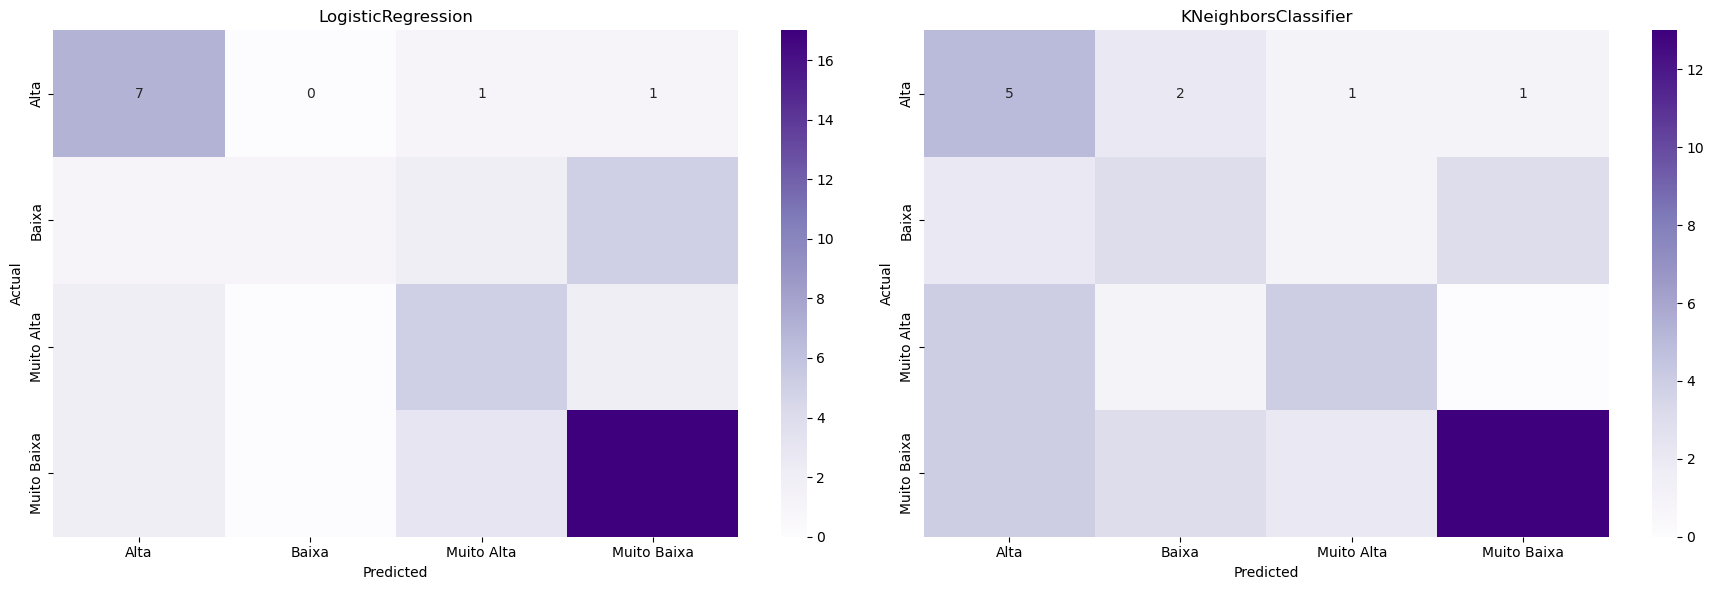

In [74]:
# Criar subplots para comparação lado a lado
fig, axes = plt.subplots(1, len(models), figsize=(18, 6))

# Loop para gerar as matrizes de confusão
for i, model in enumerate(models):
    model_name = model.__class__.__name__
    print(f"Gerando matriz de confusão para o modelo: {model_name}")
    
    # Criar o pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ])
    
    # Treinar o pipeline
    pipeline.fit(X_train, y_train)
    
    # Fazer predições
    y_pred = pipeline.predict(X_test)
    
    # Gerar a matriz de confusão
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    
    # Plotar a matriz de confusão no subplot correspondente
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_, ax=axes[i], cmap='Purples')
    axes[i].set_title(f"{model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Ajustar layout
plt.tight_layout()
plt.show()

1. **Resultados da LogisticRegression** -> Classes (Alta, Baixa, Muito Alta, Muito Baixa):

* **Alta**:
    * **Precision**: 0.58 — Das vezes que o modelo previu "Alta", 58% estavam corretas.
    * **Recall**: 0.78 — O modelo identificou corretamente 78% dos casos reais de "Alta".
    * **F1-Score**: 0.67 — Combinação equilibrada entre precisão e recall para a classe "Alta".

* **Baixa**:
    * **Precision**: 1.00 — Todas as previsões para "Baixa" estavam corretas, mas...
    * **Recall**: 0.11 — Apenas 11% dos casos reais de "Baixa" foram identificados.
    * **F1-Score**: 0.20 — Baixo devido ao recall muito baixo.

* **Muito Alta**:
    * **Precision**: 0.45 — Previsões para "Muito Alta" estavam corretas em 45% dos casos.
    * **Recall**: 0.56 — O modelo conseguiu identificar 56% dos casos reais de "Muito Alta".
    * **F1-Score**: 0.50 — Moderado desempenho para essa classe.

* **Muito Baixa**:
    * **Precision**: 0.68 — Previsões para "Muito Baixa" estavam corretas em 68% dos casos.
    * **Recall**: 0.77 — O modelo identificou 77% dos casos reais de "Muito Baixa".
    * **F1-Score**: 0.72 — Melhor desempenho geral entre as classes.

* **Métricas globais**:
    * **Accuracy**: 0.61 — O modelo acertou 61% de todas as previsões.
    * **Macro Avg**:
        * **Precision**: 0.68 — Média das precisões de todas as classes, não ponderada.
        * **Recall**: 0.55 — Média dos recalls de todas as classes.
        * **F1-Score**: 0.52 — Média das F1-scores.
* **Weighted Avg**:
    * Pondera as métricas com base no número de exemplos em cada classe.

* **Observações sobre LogisticRegression**:
 A classe "Baixa" é um ponto fraco do modelo, com recall extremamente baixo. Isso pode indicar desequilíbrio nos dados ou dificuldade do modelo em separar essa classe.
O modelo performa melhor nas classes mais frequentes, como "Muito Baixa".

2. **Resultados do KNeighborsClassifier** -> Classes (Alta, Baixa, Muito Alta, Muito Baixa):

* **Alta**:
    * **Precision**: 0.33 — Baixa precisão, apenas 33% das previsões estavam corretas.
    * **Recall**: 0.56 — O modelo identificou corretamente 56% dos casos reais de "Alta".
    * **F1-Score**: 0.42 — Desempenho moderado.

* **Baixa**:
    * **Precision**: 0.33 — Mesmo desempenho que "Alta".
    * **Recall**: 0.33 — Apenas 33% dos casos reais foram capturados.
    * **F1-Score**: 0.33 — Baixo desempenho geral.

* **Muito Alta**:
    * **Precision**: 0.50 — Melhor precisão entre as classes menores.
    * **Recall**: 0.44 — 44% dos casos reais foram identificados.
    * **F1-Score**: 0.47 — Melhor que as classes anteriores.

* **Muito Baixa**:
    * **Precision**: 0.76 — Alta precisão, 76% das previsões estavam corretas.
    * **Recall**: 0.59 — O modelo identificou 59% dos casos reais.
    * **F1-Score**: 0.67 — Melhor desempenho geral.

* **Métricas globais**:
    * **Accuracy**: 0.51 — O modelo acertou 51% de todas as previsões, pior que LogisticRegression.
    * **Macro Avg**:
        * **Precision**: 0.48 — Média das precisões é baixa.
        * **Recall**: 0.48 — Média dos recalls é equilibrada entre as classes.
        * **F1-Score**: 0.47 — Baixo desempenho médio.
    * **Weighted Avg**:
        * Reflete o mesmo comportamento com leve influência da classe "Muito Baixa".

* **Observações sobre KNeighborsClassifier**:
O modelo tem dificuldades com as classes menos frequentes, mas teve um desempenho relativamente bom na classe "Muito Baixa".
É sensível a dados locais, então pode ser necessário ajustar o número de vizinhos (n_neighbors) ou a escala dos dados.


* ### **Predição dos Modelos**

In [70]:
novos_dados = pd.DataFrame({
    "total_bill": [25.0, 40.5],
    "size": [2, 4],
    "sex": ["Female", "Male"],
    "smoker": ["No", "Yes"],
    "day": ["Sun", "Thur"],
    "time": ["Dinner", "Lunch"]
})

In [71]:
# Dicionário para armazenar as predições
predictions = {}

In [72]:
# Loop para fazer predições com todos os modelos
for model in models:
    model_name = model.__class__.__name__
    print(f"Fazendo previsão com o modelo: {model_name}")
    
    # Criar o pipeline para o modelo atual
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ])
    
    # Treinar o pipeline no conjunto completo de dados
    pipeline.fit(X, y_categorical)  # Usar o y categórico aqui
    
    # Fazer predições para os novos dados
    pred_classes = pipeline.predict(novos_dados)
    
    # Armazenar as predições no dicionário
    predictions[model_name] = pred_classes

# Exibir as predições para cada modelo
for model_name, preds in predictions.items():
    print(f"Previsões de classes para {model_name}: {preds}")


Fazendo previsão com o modelo: LogisticRegression
Fazendo previsão com o modelo: KNeighborsClassifier
Previsões de classes para LogisticRegression: ['Alta' 'Muito Alta']
Previsões de classes para KNeighborsClassifier: ['Alta' 'Muito Alta']


**As predições feitas pelos dois modelos de classificação — LogisticRegression e KNeighborsClassifier — retornaram as mesmas classes**:

* **Primeira observação**: Previsão = "Alta"
* **Segunda observação**: Previsão = "Muito Alta"

* **Interpretação**:
    1. **Consistência entre os modelos**:
    * Ambos os modelos previram as mesmas classes para os dois novos dados, indicando que, apesar de suas abordagens diferentes (logística versus proximidade de vizinhos), eles encontraram padrões similares nos dados de entrada. Isso pode sugerir que as características dos novos dados são bem representadas no conjunto de treino.

    2. **Classe "Alta"**:
    * Para o primeiro dado, os modelos classificaram como "Alta". Isso implica que, com base nos padrões do conjunto de dados de treino, os atributos dessa observação correspondem a características comuns das entradas categorizadas como "Alta".

    3. **Classe "Muito Alta"**:
    * Para o segundo dado, ambos os modelos atribuíram a classe "Muito Alta". Isso significa que os padrões dessa observação têm maior similaridade com os dados de treino rotulados como "Muito Alta".

    4. **Possível causa da coincidência nas predições**:
    * **A similaridade nas predições pode ser explicada por**:
        * As observações inseridas podem ter características marcantes que os modelos aprenderam bem.
        * Os modelos podem ter limitações em capturar nuances de dados mais complexos, levando a predições semelhantes.

In [73]:
# Inicializar dicionários para armazenar predições e probabilidades
predictions = {}
probabilities = {}  # Adicionar esta linha

# Loop para fazer predições e analisar probabilidades com todos os modelos
for model in models:
    model_name = model.__class__.__name__
    print(f"Fazendo previsão com o modelo: {model_name}")
    
    # Criar o pipeline para o modelo atual
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ])
    
    # Treinar o pipeline no conjunto completo de dados
    pipeline.fit(X, y_categorical)  # Usar o y categórico aqui
    
    # Fazer predições para os novos dados
    pred_classes = pipeline.predict(novos_dados)
    
    # Armazenar as predições no dicionário
    predictions[model_name] = pred_classes

    # Verificar se o modelo suporta predict_proba
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        pred_probs = pipeline.predict_proba(novos_dados)
        probabilities[model_name] = pred_probs  # Armazenar as probabilidades
    
# Exibir as predições para cada modelo
for model_name, preds in predictions.items():
    print(f"Previsões de classes para {model_name}: {preds}")
    if model_name in probabilities:
        print(f"Probabilidades das classes para {model_name}:")
        for i, prob in enumerate(probabilities[model_name]):
            print(f"Dado {i + 1}: {prob}")


Fazendo previsão com o modelo: LogisticRegression
Fazendo previsão com o modelo: KNeighborsClassifier
Previsões de classes para LogisticRegression: ['Alta' 'Muito Alta']
Probabilidades das classes para LogisticRegression:
Dado 1: [0.48898787 0.19861949 0.26569181 0.04670083]
Dado 2: [0.11669773 0.02102794 0.86028388 0.00199045]
Previsões de classes para KNeighborsClassifier: ['Alta' 'Muito Alta']
Probabilidades das classes para KNeighborsClassifier:
Dado 1: [0.4 0.2 0.2 0.2]
Dado 2: [0.4 0.  0.6 0. ]


**Modelo: LogisticRegression**

* **Dado 1**:

    * **Alta**: 48.90% de probabilidade (maior probabilidade, justificando a classe prevista como 'Alta').
    * **Baixa**: 19.86% de probabilidade.
    * **Muito Alta**: 26.57% de probabilidade.
    * **Muito Baixa**: 4.67% de probabilidade.
    * **Interpretação**: O modelo está relativamente confiante na classe 'Alta', mas há alguma incerteza devido às probabilidades consideráveis em 'Muito Alta'.

* **Dado 2**:

    * **Alta**: 11.67% de probabilidade.
    * **Baixa**: 2.10% de probabilidade.
    * **Muito Alta**: 86.03% de probabilidade (maior probabilidade, justificando a classe prevista como 'Muito Alta').
    * **Muito Baixa**: 0.20% de probabilidade.
    * **Interpretação**: O modelo está altamente confiante de que a classe correta é 'Muito Alta'.

**Modelo: KNeighborsClassifier**

* **Dado 1**:

    * **Alta**: 40% de probabilidade (maior probabilidade, justificando a classe prevista como 'Alta').
    * **Baixa**: 20% de probabilidade.
    * **Muito Alta**: 20% de probabilidade.
    * **Muito Baixa**: 20% de probabilidade.
    * **Interpretação**: O modelo apresenta uma divisão mais equilibrada das probabilidades, sugerindo menor confiança na previsão de 'Alta'.

* **Dado 2**:

    * **Alta**: 40% de probabilidade.
    * **Baixa**: 0% de probabilidade.
    * **Muito Alta**: 60% de probabilidade (maior probabilidade, justificando a classe prevista como 'Muito Alta').
    * **Muito Baixa**: 0% de probabilidade.
    * **Interpretação**: Apesar de menos confiança geral comparada ao LogisticRegression, o modelo mostra uma decisão clara entre 'Alta' e 'Muito Alta', favorecendo esta última.

## Insights

* ### **Modelos de Regressão**:

| Métrica                | Melhor Modelo     | Justificativa                                                                 |
|------------------------|-------------------|-------------------------------------------------------------------------------|
| Tempo de Treinamento   | DummyRegressor    | É o mais rápido de treinar, já que apenas calcula a média.                    |
| Tempo de Previsão      | SVR              | É o mais rápido para realizar predições.                                     |
| MAE, MSE e MAPE        | SVR              | Apresentou os menores erros em todas as métricas.                            |
| R²                     | SVR              | Melhor capacidade de explicação da variância dos dados com um R² de 0.420621. |


O SVR (Support Vector Regression) foi o modelo com melhor desempenho geral em termos de erro e explicação dos dados (R²). No entanto, também apresenta um tempo de treinamento relativamente mais alto. O DummyRegressor serve como referência e demonstrou desempenho ruim, como esperado.

Se o foco for alta precisão, o SVR é a melhor escolha. Porém, caso o tempo de treinamento seja uma restrição, o LinearRegression também é uma opção razoável.

| Modelo               | Variação das Previsões | Captura de Padrões nos Dados | Observações                                                                                      |
|-----------------------|-----------------------|-----------------------------|--------------------------------------------------------------------------------------------------|
| DummyRegressor       | Nenhuma (constante)   | Nenhuma                     | Serve como baseline, apenas retornando o valor médio.                                            |
| LinearRegression     | Moderada             | Relações lineares           | Bom para capturar padrões lineares; limitações em relações mais complexas.                      |
| KNeighborsRegressor  | Moderada             | Relações locais             | Previsões dependem da densidade dos dados; bom para padrões não lineares em regiões densas.      |
| SVR                  | Alta                 | Relações não lineares e globais | Captura padrões mais complexos; boa variação nas predições reflete maior adaptação às entradas. |


* O DummyRegressor falha em capturar qualquer padrão, sendo usado apenas como referência básica.
* O LinearRegression é eficaz para padrões lineares, mas pode falhar em dados mais complexos.
* O KNeighborsRegressor oferece previsões locais, adaptando-se bem em regiões densas do espaço de dados.
* O SVR apresenta a melhor capacidade de adaptação, mostrando uma variação nas predições que reflete bem a diversidade nos dados de entrada.
* Se o objetivo é capturar relações complexas para prever o valor da gorjeta com maior precisão, o SVR parece ser o modelo mais promissor.

* ### **Modelos de Classificação**:

| Métrica                | Melhor Modelo           | Justificativa                                                                 |
|------------------------|-------------------------|-------------------------------------------------------------------------------|
| Precision (ponderada)  | LogisticRegression      | Apresentou melhor precisão ponderada com 0.68, indicando previsões mais precisas. |
| Recall (ponderado)     | LogisticRegression      | Recall de 0.61, melhor identificação geral das classes verdadeiras.           |
| F1-Score (ponderado)   | LogisticRegression      | Melhor equilíbrio entre precisão e recall, com F1 ponderado de 0.58.          |
| Accuracy               | LogisticRegression      | Acurácia de 61%, maior que KNeighborsClassifier.                              |
| Melhor desempenho em "Muito Baixa" | LogisticRegression      | Maior recall e F1-score para a classe mais frequente.                         |
| Classes minoritárias   | KNeighborsClassifier    | Melhor equilíbrio para as classes menores, com precisão similar entre elas.   |


* LogisticRegression apresentou melhor desempenho geral, com maior accuracy (61%) e melhores métricas ponderadas. No entanto, teve dificuldades com a classe "Baixa".
* KNeighborsClassifier teve accuracy menor (51%) e maior dificuldade em capturar padrões gerais, especialmente nas classes menores.

| Modelo               | Consistência das Previsões | Captura de Padrões nos Dados  | Observações                                                                                      |
|-----------------------|---------------------------|--------------------------------|--------------------------------------------------------------------------------------------------|
| LogisticRegression    | Alta                     | Relações lineares e globais   | Previu as classes "Alta" e "Muito Alta" de forma consistente; confiável em dados bem estruturados. |
| KNeighborsClassifier  | Alta                     | Relações locais               | Previu as mesmas classes que o LogisticRegression; bom para identificar padrões próximos nos dados. |


* Apesar de ambos concordarem nas previsões, é importante considerar as métricas de avaliação (como precision e recall) para decidir qual modelo é mais confiável.
* O LogisticRegression apresenta maior confiança nas previsões devido à distribuição mais pronunciada das probabilidades, especialmente para o segundo dado.
* O KNeighborsClassifier tende a ser menos confiante nas previsões, especialmente para o primeiro dado, com uma divisão mais uniforme das probabilidades.